#**02_TERM FREQUENCY AND TFIDF**

Summary:


1.   Load Back Data and Merging
2.   Split *narco_data* into Schedules ([DEA](https://www.dea.gov/drug-information/drug-scheduling))
3.   Term Frequency
4.   TfIdf on Schedule 1 and Schedule 2
5.   TfIdf with respect to Time Periods

---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/My Drive/Università/inforet_prj/')

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
import pandas as pd
import pickle
import spacy
import string
#import seaborn as sns; sns.set()
from scipy.stats import norm
import matplotlib.pyplot as plt
import math

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import string

In [3]:
nlp = spacy.load("en_core_web_sm")

In [35]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

## **1. Load Back Data and Merging**

In [7]:
narco_nlp = pd.read_csv("/content/drive/MyDrive/Università/inforet_prj/narco_nlp_21set_nostop.csv", sep="|", names = ['spacy_nlp'], header=None)
narco_nlp

,spacy_nlp
0,indict count murder aggravate criminal sexual ...
1,issue consolidated appeal constitutionality en...
2,subject appeal interlocutory order enter juven...
3,charge indictment single count possession cont...
4,indict aggravate criminal sexual assault unlaw...
...,...
6071,agree majority decision affirm trial order gra...
6072,trial convict defendant possession control sub...
6073,grant motion dismiss certain indictment statut...
6074,jury trial defendant find hable medical malpra...


In [8]:
narco_df = pd.read_csv("/content/drive/MyDrive/Università/inforet_prj/narco_df.csv", sep="|")
narco_df

,type,text,author,id,year
0,majority,CHIEF JUSTICE HEIPLE\ndelivered the opinion of...,CHIEF JUSTICE HEIPLE,1,1997
1,majority,JUSTICE BILANDIC\ndelivered the opinion of the...,JUSTICE BILANDIC,5,1997
2,majority,JUSTICE ZWICK\ndelivered the opinion of the co...,JUSTICE ZWICK,8,1997
3,majority,PRESIDING JUSTICE GREIMAN\ndelivered the opini...,PRESIDING JUSTICE GREIMAN,44,1997
4,majority,PRESIDING JUSTICE CAHILL\ndelivered the opinio...,PRESIDING JUSTICE CAHILL,55,2000
...,...,...,...,...,...
6071,concurrence,"JUSTICE McNAMARA,\nspecially concurring:\nI ag...","JUSTICE McNAMARA,",183077,1986
6072,majority,PRESIDING JUSTICE WOLFSON\ndelivered the opini...,PRESIDING JUSTICE WOLFSON,183094,2007
6073,majority,Mr. PRESIDING JUSTICE GOLDBERG\ndelivered the ...,Mr. PRESIDING JUSTICE GOLDBERG,183108,1976
6074,majority,PRESIDING JUSTICE QUINN\ndelivered the opinion...,PRESIDING JUSTICE QUINN,183124,2006


In [9]:
narco_data = pd.concat([narco_df, narco_nlp], axis=1)

In [10]:
narco_data = narco_data.rename(columns= {'spacy_nlp':'lemmatized'})
narco_data.lemmatized

0       indict count murder aggravate criminal sexual ...
1       issue consolidated appeal constitutionality en...
2       subject appeal interlocutory order enter juven...
3       charge indictment single count possession cont...
4       indict aggravate criminal sexual assault unlaw...
                              ...                        
6071    agree majority decision affirm trial order gra...
6072    trial convict defendant possession control sub...
6073    grant motion dismiss certain indictment statut...
6074    jury trial defendant find hable medical malpra...
6075    charge indictment count murder count armed vio...
Name: lemmatized, Length: 6076, dtype: object

In [11]:
del narco_df
del narco_nlp

In [12]:
import gc
gc.collect()

229

### *1.1 Serialize narco_data*

In [13]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_data.pkl", "wb") as f:
    pickle.dump(narco_data, f)

---

## **2. Split *narco_data* into Schedules**

In [4]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_data.pkl", "rb") as f:
    narco_data = pickle.load(f)

In [5]:
schedule_1 = ["cannabis",  "marijuana",  "lsd", "heroin", 'methaqualone', "ecstasy", "peyote", "mescaline", "mda", "mdma"] #https://www.dea.gov/drug-information/drug-scheduling
schedule_2 = ["cocaine", "methamphetamine", "hydromorphone", "dilaudid", "meperidine", "demerol", "oxycodone", "dexedrine", "fentanyl", "ritalin", "methadone", "amphetamine", "phencyclidine", "pseudoephedrine", "ephedrine", "meth", "opium", "dilaudid", "preludin"]
schedule_3 = ["ketamine", "anabolic" , "steroids",  "testosterone", "ketamine"]
schedule_4 = ["modafinil", "provigil", "adderall", "methylphenidate", "memantine", "axura", "soma", "xanax", "darvon", "darvocet", "valium", "ativan", "talwin", "ambien", "tramadol",  "ethclorvynol"]
schedule_5 = ["phenylpropanolamine", "lomotil", "motofen", "lyrica", "parepectolin", "tetracaine"]

In [6]:
conditions = [
    (narco_data['lemmatized'].str.contains("|".join(schedule_1))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_3))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_2))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_4))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_5))),
    (narco_data['lemmatized'].str.contains("|".join(schedule_2))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_3))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_1))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_4))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_5))),
    (narco_data['lemmatized'].str.contains("|".join(schedule_3))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_1))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_2))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_4))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_5))),
    (narco_data['lemmatized'].str.contains("|".join(schedule_4))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_3))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_2))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_1))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_5)))
    ]

# create a list of the values we want to assign for each condition
values = ['narco_1', 'narco_2', 'narco_3', 'narco_4']

# create a new column and use np.select to assign values to it using our lists as arguments
narco_data['schedule'] = np.select(conditions, values)

# display updated DataFrame
narco_data.head()

,type,text,author,id,year,lemmatized,schedule
0,majority,CHIEF JUSTICE HEIPLE\ndelivered the opinion of...,CHIEF JUSTICE HEIPLE,1,1997,indict count murder aggravate criminal sexual ...,narco_2
1,majority,JUSTICE BILANDIC\ndelivered the opinion of the...,JUSTICE BILANDIC,5,1997,issue consolidated appeal constitutionality en...,0
2,majority,JUSTICE ZWICK\ndelivered the opinion of the co...,JUSTICE ZWICK,8,1997,subject appeal interlocutory order enter juven...,narco_2
3,majority,PRESIDING JUSTICE GREIMAN\ndelivered the opini...,PRESIDING JUSTICE GREIMAN,44,1997,charge indictment single count possession cont...,narco_2
4,majority,PRESIDING JUSTICE CAHILL\ndelivered the opinio...,PRESIDING JUSTICE CAHILL,55,2000,indict aggravate criminal sexual assault unlaw...,0


In [7]:
narco_sch = narco_data.loc[:, ["schedule", "lemmatized"]]

In [8]:
narco_sch

,schedule,lemmatized
0,narco_2,indict count murder aggravate criminal sexual ...
1,0,issue consolidated appeal constitutionality en...
2,narco_2,subject appeal interlocutory order enter juven...
3,narco_2,charge indictment single count possession cont...
4,0,indict aggravate criminal sexual assault unlaw...
...,...,...
6071,0,agree majority decision affirm trial order gra...
6072,narco_2,trial convict defendant possession control sub...
6073,0,grant motion dismiss certain indictment statut...
6074,0,jury trial defendant find hable medical malpra...


In [69]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_sch.pkl", "wb") as f:
    pickle.dump(narco_sch, f)

In [9]:
# NARCO SCHEDULE MERGE
# Merge in one row all the opinions in the same schedule.
# We obtain narco_schedule with shape 5,2:
#   _0 (miscellaneous), narco_1, narco_2, narco_3, narco_4;
#   _schedule label and lemmatized corpora.

narco_schedule = narco_sch.groupby('schedule', as_index=False).agg({'lemmatized' : ' '.join}) 

In [17]:
narco_sch.loc[narco_sch.schedule == '0']

,schedule,lemmatized
1,0,issue consolidated appeal constitutionality en...
4,0,indict aggravate criminal sexual assault unlaw...
13,0,charge indictment aggravated discharge firearm...
15,0,issue traffic citation drive influence alcohol...
16,0,try degree murder armed robbery connection dea...
...,...,...
6069,0,appeal appellate affirm defendant conviction s...
6070,0,appeal dismissal action count defendant indivi...
6071,0,agree majority decision affirm trial order gra...
6073,0,grant motion dismiss certain indictment statut...


In [11]:
narco_schedule.lemmatized.str.split(" ").map(len)

0    2828935
1    1294404
2    3075837
3       2002
4       7767
Name: lemmatized, dtype: int64

### *2.1 Serialize narco_schedule*

In [12]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_schedule.pkl", "wb") as f:
    pickle.dump(narco_schedule, f)

---

## **3. Term Frequency**

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_schedule.pkl", "rb") as f:
  narco_schedule = pickle.load(f)

In [18]:
# Divide 
# narco_schedule.loc[narco_schedule.schedule == "0"] #2361 
narco_schedule_1 = narco_schedule.loc[narco_schedule['schedule']=="narco_1"] # 1421     
narco_schedule_2 = narco_schedule.loc[narco_schedule['schedule']=="narco_2"] # 2287   
#narco_schedule_3 = narco_schedule.loc[narco_schedule['schedule']=="narco_3"] # 1
#narco_schedule_4 = narco_schedule.loc[narco_schedule['schedule']=="narco_4"] # 6

In [19]:
nar = narco_schedule[(narco_schedule.schedule == 'narco_1') | (narco_schedule.schedule =='narco_2')]

In [20]:
vectorizer = CountVectorizer()
vector_narco = vectorizer.fit_transform(nar['lemmatized'])

words_list = vectorizer.get_feature_names()
count_list = vector_narco.toarray().sum(axis=0)

w = dict(zip(words_list, count_list))
w = {k: v for k, v in sorted(w.items(), key=lambda item: item[1], reverse=True)}

mcw = pd.DataFrame.from_dict(w, orient='index').reset_index()
mcw.columns = ["words_tot", "abs_freq"]

mcw["rel_freq"] = mcw.progress_apply(lambda x: np.round(x.abs_freq / mcw.abs_freq.sum(), 3), axis=1)

mcw[:50]

100%|██████████| 22986/22986 [00:02<00:00, 7869.40it/s]


,words_tot,abs_freq,rel_freq
0,defendant,187283,0.043
1,trial,71080,0.016
2,evidence,47901,0.011
3,testify,32825,0.008
4,find,31134,0.007
5,officer,28266,0.006
6,police,26877,0.006
7,state,23468,0.005
8,testimony,23099,0.005
9,jury,22647,0.005


In [ ]:
vectorizer = CountVectorizer()
#words_list = vectorizer.get_feature_names()
#
X = vectorizer.fit_transform(narco_schedule_1['lemmatized'])
words_list_1 = vectorizer.get_feature_names()
count_list_1 = X.toarray().sum(axis=0)
w_1 = dict(zip(words_list_1, count_list_1))
w_1 = {k: v for k, v in sorted(w_1.items(), key=lambda item: item[1], reverse=True)}
mcw_1 = pd.DataFrame.from_dict(w_1, orient='index').reset_index()
mcw_1.columns = ["words_1", "abs_freq"]
mcw_1["rel_freq"] = mcw_1.progress_apply(lambda x: np.round(x.abs_freq / mcw_1.abs_freq.sum(), 3), axis=1)
mcw_1["log_freq"] = mcw_1.progress_apply(lambda x: np.round(1+(math.log(x.abs_freq,5)), 3), axis=1)
mcw_1["augm_freq"] = mcw_1.progress_apply(lambda x: np.round(0.5+(0.5*x.abs_freq / mcw_1.abs_freq.max()), 3), axis=1)
#
Y = vectorizer.fit_transform(narco_schedule_2['lemmatized'])
words_list_2 = vectorizer.get_feature_names()
count_list_2 = Y.toarray().sum(axis=0)
w_2 = dict(zip(words_list_2, count_list_2))
w_2 = {k: v for k, v in sorted(w_2.items(), key=lambda item: item[1], reverse=True)}
mcw_2 = pd.DataFrame.from_dict(w_2, orient='index').reset_index()
mcw_2.columns = ["words_2", "abs_freq"]
mcw_2["rel_freq"] = mcw_2.progress_apply(lambda x: np.round(x.abs_freq / mcw_2.abs_freq.sum(), 3), axis=1)
mcw_2["log_freq"] = mcw_2.progress_apply(lambda x: np.round(1+(math.log(x.abs_freq,5)), 3), axis=1)
mcw_2["augm_freq"] = mcw_2.progress_apply(lambda x: np.round(0.5+(0.5*x.abs_freq / mcw_2.abs_freq.max()), 3), axis=1)

In [22]:
mcw_1_2_concat = pd.concat([mcw_1[:20],mcw_2[:20]], axis=1)
mcw_1_2_concat # WORDS = tinfou, mitte, wtappe

,words_1,abs_freq,rel_freq,log_freq,augm_freq,words_2,abs_freq,rel_freq,log_freq,augm_freq
0,defendant,55758,0.043,7.790,1.000,defendant,131525,0.043,8.324,1.000
1,trial,20140,0.016,7.158,0.681,trial,50940,0.017,7.734,0.694
2,evidence,13853,0.011,6.925,0.624,evidence,34048,0.011,7.484,0.629
3,officer,10017,0.008,6.724,0.590,testify,22956,0.007,7.239,0.587
4,testify,9869,0.008,6.715,0.588,find,21672,0.007,7.203,0.582
5,find,9462,0.007,6.688,0.585,police,18391,0.006,7.101,0.570
6,police,8486,0.007,6.621,0.576,officer,18249,0.006,7.096,0.569
7,search,7695,0.006,6.560,0.569,state,16798,0.005,7.045,0.564
8,testimony,7462,0.006,6.541,0.567,jury,16595,0.005,7.037,0.563
9,arrest,6910,0.005,6.493,0.562,testimony,15637,0.005,7.000,0.559


In [23]:
common_terms = list(set(mcw_1["words_1"][:10].values).intersection(set(mcw_2["words_2"][:200].values)))
common_terms

['evidence',
 'testify',
 'police',
 'find',
 'trial',
 'defendant',
 'search',
 'officer',
 'arrest',
 'testimony']

In [ ]:
# COMMON
a = mcw.words_tot[:50]
b = mcw_1.words_1[:50]
c = mcw_2.words_2[:50]
ab = pd.DataFrame([ element for element in a if element in b], columns = ['tot_narco1'])
ac = pd.DataFrame([ element for element in a if element in c], columns = ['tot_narco2'])
bc = pd.DataFrame([ element for element in b if element in c], columns = ['narco1_narco2'])
#x = pd.concat([ab, ac,bc],axis=1 ) 
bc

In [25]:
df_top50 = pd.concat([a, b, c],axis=1) ## MOLTO STRANO!!
df_top50[:10]

,words_tot,words_1,words_2
0,defendant,defendant,defendant
1,trial,trial,trial
2,evidence,evidence,evidence
3,testify,officer,testify
4,find,testify,find
5,officer,find,police
6,police,police,officer
7,state,search,state
8,testimony,testimony,jury
9,jury,arrest,testimony


In [26]:
# NOT COMMON ## NON FUNZIONA?!
a = mcw.words_tot[:30]
b = mcw_1.words_1[:30]
c = mcw_2.words_2[:30]
ab = pd.DataFrame([ element for element in a if element not in b], columns = ['tot_narco1'])
ac = pd.DataFrame([ element for element in a if element not in c], columns = ['tot_narco2'])
bc = pd.DataFrame([ element for element in b if element not in c], columns = ['narco1_narco2'])
x = pd.concat([ab, ac,bc], axis=1 ) 
x

,tot_narco1,tot_narco2,narco1_narco2
0,defendant,defendant,defendant
1,trial,trial,trial
2,evidence,evidence,evidence
3,testify,testify,officer
4,find,find,testify
5,officer,officer,find
6,police,police,police
7,state,state,search
8,testimony,testimony,testimony
9,jury,jury,arrest


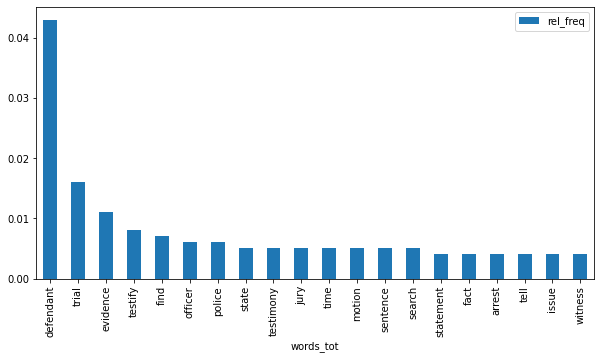

In [27]:
mcw[:20].plot(x="words_tot", y="rel_freq", kind="bar", figsize=(10,5)) 
plt.show()

In [ ]:
mcw["augm_freq"] = mcw.progress_apply(lambda x: np.round(0.5+(0.5*x.abs_freq / mcw.abs_freq.max()), 3), axis=1)

Text(0, 0.5, 'Augemnted Frequency')

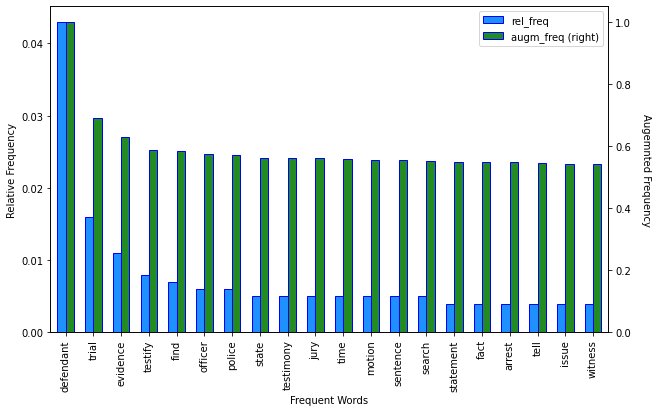

In [29]:
mcw_freqs = mcw[['words_tot','rel_freq','augm_freq']]
ax = mcw_freqs[:20].plot(kind='bar', x = 'words_tot', secondary_y = 'augm_freq', color={"rel_freq": "dodgerblue", "augm_freq": "forestgreen"}, edgecolor='blue', figsize=(10,6), width= 0.6)

ax.set_xlabel("Frequent Words")
ax.set_ylabel("Relative Frequency")
plt.ylabel('Augemnted Frequency', rotation=-90, labelpad=20)

---

## **4. TfIdf on Schedule 1 and Schedule 2**

In [30]:
nar = narco_schedule[(narco_schedule.schedule == 'narco_1') | (narco_schedule.schedule =='narco_2')]

In [31]:
nar

,schedule,lemmatized
1,narco_1,appeal order dismiss untimely postconviction p...
2,narco_2,indict count murder aggravate criminal sexual ...


In [36]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(nar['lemmatized'])
tfidf_1 = tfidf_vectorizer.transform(narco_schedule_1['lemmatized'])
tfidf_2 = tfidf_vectorizer.transform(narco_schedule_2['lemmatized'])
feature_names=tfidf_vectorizer.get_feature_names()
items_1=sort_coo(tfidf_1.tocoo())
items_2=sort_coo(tfidf_2.tocoo())
keyw_1=extract_topn_from_vector(feature_names,items_1,30)
keyw_2=extract_topn_from_vector(feature_names,items_2,30)
keyw_1 = pd.DataFrame(list(keyw_1.items()),columns = ['word_1','tfidf_1'])
keyw_2 = pd.DataFrame(list(keyw_2.items()),columns = ['word_2','tfidf_2']) 
tfidf_schedule_drugs = pd.concat([keyw_1, keyw_2], axis=1)
tfidf_schedule_drugs

,word_1,tfidf_1,word_2,tfidf_2
0,defendant,0.719,defendant,0.724
1,trial,0.260,trial,0.280
2,evidence,0.179,evidence,0.187
3,officer,0.129,testify,0.126
4,testify,0.127,find,0.119
5,find,0.122,police,0.101
6,police,0.109,officer,0.100
7,search,0.099,state,0.092
8,testimony,0.096,cocaine,0.092
9,arrest,0.089,jury,0.091


In [37]:
#int_df = pd.merge(keyw_1, keyw_2, how ='inner', on =['word', 'word'])
#print(int_df)

In [38]:
pd.DataFrame([ element for element in keyw_1.word_1[:20] if element not in keyw_2.word_2[:20]], columns = ['tot_narco1']) ## NON FUNZIONA!!

,tot_narco1
0,defendant
1,trial
2,evidence
3,officer
4,testify
5,find
6,police
7,search
8,testimony
9,arrest


---

## **5. TfIdf with respect to Time Periods**

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_data.pkl", "rb") as f:
  narco_data = pickle.load(f)

In [ ]:
schedule_1 = ["cannabis",  "marijuana",  "lsd", "heroin", 'methaqualone', "ecstasy", "peyote" ] #https://www.dea.gov/drug-information/drug-scheduling
schedule_2 = ["cocaine", "methamphetamine", "hydromorphone", "dilaudid", "meperidine", "demerol", "oxycodone", "dexedrine", "fentanyl", "ritalin", "methadone"]
schedule_3 = ["ketamine", "anabolic" , "steroids",  "testosterone"]
schedule_4 = ["modafinil", "provigil", "adderall", "methylphenidate", "memantine", "axura"] #SMART DRUGS 

#### 5.1 **Schedule 1**: *narco_1_time* building

In [48]:
narco_data_1 = narco_data[(narco_data['lemmatized'].str.contains("|".join(schedule_1))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_3))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_2))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_4)))] # 1741 

In [49]:
narco_1_time = narco_data_1.drop(['type','text','author', 'id'], axis = 1)

In [50]:
narco_1_time.loc[(narco_1_time["year"] >= 1950) & (narco_1_time["year"] <= 1959), 'year'] = 50 # 33
narco_1_time.loc[(narco_1_time["year"] >= 1960) & (narco_1_time["year"] <= 1969), 'year'] = 60 # 222
narco_1_time.loc[(narco_1_time["year"] >= 1970) & (narco_1_time["year"] <= 1979), 'year'] = 70 # 560
narco_1_time.loc[(narco_1_time["year"] >= 1980) & (narco_1_time["year"] <= 1989), 'year'] = 80 # 414
narco_1_time.loc[(narco_1_time["year"] >= 1990) & (narco_1_time["year"] <= 1999), 'year'] = 90 # 251
narco_1_time.loc[(narco_1_time["year"] >= 2000) & (narco_1_time["year"] <= 2009), 'year'] = 10 # 229

In [51]:
narco_1_time.loc[narco_1_time["year"] == 50, 'year'] = '50s' 
narco_1_time.loc[narco_1_time["year"] == 60, 'year'] = '60s' 
narco_1_time.loc[narco_1_time["year"] == 70, 'year'] = '70s' 
narco_1_time.loc[narco_1_time["year"] == 80, 'year'] = '80s' 
narco_1_time.loc[narco_1_time["year"] == 90, 'year'] = '90s'
narco_1_time.loc[narco_1_time["year"] == 10, 'year'] = '00s'

In [52]:
narco_1_time.loc[narco_1_time.year == '00s'].shape

(193, 3)

In [53]:
narco_1_time.drop(narco_1_time.loc[(narco_1_time["year"] != '50s' ) & (narco_1_time["year"] != '60s') & (narco_1_time["year"] != '70s') & (narco_1_time["year"] != '80s') & (narco_1_time["year"] != '90s') & (narco_1_time["year"] != '00s')].index, inplace=True)

In [54]:
narco_1_time = narco_1_time.groupby('year', as_index=False).agg({'lemmatized' : ' '.join})  

In [55]:
narco_1_50s = narco_1_time.loc[narco_1_time['year']=="50s"] # 2507  
narco_1_60s = narco_1_time.loc[narco_1_time['year']=="60s"] 
narco_1_70s = narco_1_time.loc[narco_1_time['year']=="70s"]
narco_1_80s = narco_1_time.loc[narco_1_time['year']=="80s"]
narco_1_90s = narco_1_time.loc[narco_1_time['year']=="90s"]
narco_1_00s = narco_1_time.loc[narco_1_time['year']=="00s"]

In [ ]:
#with open("/content/drive/MyDrive/Università/inforet_prj/narco_1_time.pkl", "wb") as f:
#    pickle.dump(narco_s1_time, f)

#### 5.2 **Schedule 1**: TfIdf *narco_1_time*

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_s1_time.pkl", "rb") as f:
  narco_s1_time = pickle.load(f)

In [56]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(narco_1_time['lemmatized'])
tfidf_50_59 = tfidf_vectorizer.transform(narco_1_50s['lemmatized'])
tfidf_60_69 = tfidf_vectorizer.transform(narco_1_60s['lemmatized'])
tfidf_70_79 = tfidf_vectorizer.transform(narco_1_70s['lemmatized'])
tfidf_80_89 = tfidf_vectorizer.transform(narco_1_80s['lemmatized'])
tfidf_90_99 = tfidf_vectorizer.transform(narco_1_90s['lemmatized'])
tfidf_00_09 = tfidf_vectorizer.transform(narco_1_00s['lemmatized'])
feature_names=tfidf_vectorizer.get_feature_names()
items_50_59=sort_coo(tfidf_50_59.tocoo())
items_60_69=sort_coo(tfidf_60_69.tocoo())
items_70_79=sort_coo(tfidf_70_79.tocoo())
items_80_89=sort_coo(tfidf_80_89.tocoo())
items_90_99=sort_coo(tfidf_90_99.tocoo())
items_00_09=sort_coo(tfidf_00_09.tocoo())
keyw_50_59=extract_topn_from_vector(feature_names,items_50_59,30)
keyw_60_69=extract_topn_from_vector(feature_names,items_60_69,30)
keyw_70_79=extract_topn_from_vector(feature_names,items_70_79,30)
keyw_80_89=extract_topn_from_vector(feature_names,items_80_89,30)
keyw_90_99=extract_topn_from_vector(feature_names,items_90_99,30)
keyw_00_09=extract_topn_from_vector(feature_names,items_00_09,30)
keyw_50_59 = pd.DataFrame(list(keyw_50_59.items()),columns = ['word_50','tfidf'])
keyw_60_69 = pd.DataFrame(list(keyw_60_69.items()),columns = ['word_60','tfidf']) 
keyw_70_79 = pd.DataFrame(list(keyw_70_79.items()),columns = ['word_70','tfidf']) 
keyw_80_89 = pd.DataFrame(list(keyw_80_89.items()),columns = ['word_80','tfidf']) 
keyw_90_99 = pd.DataFrame(list(keyw_90_99.items()),columns = ['word_90','tfidf']) 
keyw_00_09 = pd.DataFrame(list(keyw_00_09.items()),columns = ['word_95','tfidf'])

In [57]:
tfidf_years = pd.concat([keyw_50_59, keyw_60_69, keyw_70_79, keyw_80_89, keyw_90_99, keyw_00_09], axis=1)
tfidf_years

,word_50,tfidf,word_60,tfidf,word_70,tfidf,word_80,tfidf,word_90,tfidf,word_95,tfidf
0,defendant,0.488,defendant,0.655,defendant,0.685,defendant,0.721,defendant,0.727,defendant,0.730
1,officer,0.257,narcotic,0.276,trial,0.251,trial,0.256,trial,0.276,trial,0.266
2,narcotic,0.244,officer,0.192,evidence,0.178,evidence,0.175,evidence,0.184,evidence,0.166
3,error,0.196,trial,0.178,officer,0.145,find,0.119,find,0.127,officer,0.117
4,evidence,0.190,evidence,0.172,search,0.129,testify,0.117,testify,0.127,find,0.116
5,testify,0.173,testify,0.168,testify,0.125,police,0.116,officer,0.107,testify,0.112
6,arrest,0.169,arrest,0.143,find,0.118,officer,0.113,police,0.097,police,0.104
7,trial,0.144,informer,0.141,testimony,0.114,testimony,0.098,search,0.092,motion,0.090
8,search,0.129,testimony,0.134,police,0.111,arrest,0.098,statement,0.091,time,0.081
9,find,0.128,police,0.123,arrest,0.103,sentence,0.097,testimony,0.088,state,0.081


#### **5.2 Schedule 2**: *narco_2_time* building

In [58]:
narco_data_2 = narco_data[(narco_data['lemmatized'].str.contains("|".join(schedule_2))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_3))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_1))) & ~(narco_data['lemmatized'].str.contains("|".join(schedule_4)))] # 1770 

In [59]:
narco_2_time = narco_data_2.drop(['type','text','author', 'id'], axis = 1)

In [60]:
# 5-years blocks between 1980 and 2009.
narco_2_time.loc[(narco_2_time["year"] >= 1980) & (narco_2_time["year"] <= 1984), 'year'] = 80 # 102
narco_2_time.loc[(narco_2_time["year"] >= 1985) & (narco_2_time["year"] <= 1989), 'year'] = 85 # 233
narco_2_time.loc[(narco_2_time["year"] >= 1990) & (narco_2_time["year"] <= 1994), 'year'] = 90 # 566
narco_2_time.loc[(narco_2_time["year"] >= 1995) & (narco_2_time["year"] <= 1999), 'year'] = 95 # 292
narco_2_time.loc[(narco_2_time["year"] >= 2000) & (narco_2_time["year"] <= 2004), 'year'] = 00 # 350
narco_2_time.loc[(narco_2_time["year"] >= 2005) & (narco_2_time["year"] <= 2009), 'year'] = 5 # 278

In [61]:
narco_2_time.loc[narco_2_time["year"] == 80, 'year'] = '80s' 
narco_2_time.loc[narco_2_time["year"] == 85, 'year'] = '85s' 
narco_2_time.loc[narco_2_time["year"] == 90, 'year'] = '90s' 
narco_2_time.loc[narco_2_time["year"] == 95, 'year'] = '95s' 
narco_2_time.loc[narco_2_time["year"] == 00, 'year'] = '00s'
narco_2_time.loc[narco_2_time["year"] == 5, 'year'] = '05s'

In [62]:
narco_2_time.drop(narco_2_time.loc[(narco_2_time["year"] != '80s' ) & (narco_2_time["year"] != '85s') & (narco_2_time["year"] != '90s') & (narco_2_time["year"] != '95s') & (narco_2_time["year"] != '00s') & (narco_2_time["year"] != '05s')].index, inplace=True)

In [63]:
narco_2_time = narco_2_time.groupby('year', as_index=False).agg({'lemmatized' : ' '.join})  

In [65]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_s2_time.pkl", "wb") as f:
    pickle.dump(narco_s2_time, f)

#### **5.4 Schedule 2**: TfIdf *narco_2_time*

In [ ]:
with open("/content/drive/MyDrive/Università/inforet_prj/narco_s2_time.pkl", "rb") as f:
  narco_s2_time = pickle.load(f)

In [66]:
# Create new df for each period (from 80s to 00s)
narco_2_80s = narco_2_time.loc[narco_2_time['year']=="80s"] # 2507  
narco_2_85s = narco_2_time.loc[narco_2_time['year']=="85s"] 
narco_2_90s = narco_2_time.loc[narco_2_time['year']=="90s"]
narco_2_95s = narco_2_time.loc[narco_2_time['year']=="95s"]
narco_2_00s = narco_2_time.loc[narco_2_time['year']=="00s"]
narco_2_05s = narco_2_time.loc[narco_2_time['year']=="05s"]

In [67]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(narco_2_time['lemmatized'])
tfidf_80_84_2 = tfidf_vectorizer.transform(narco_2_80s['lemmatized'])
tfidf_85_89_2 = tfidf_vectorizer.transform(narco_2_85s['lemmatized'])
tfidf_90_94_2 = tfidf_vectorizer.transform(narco_2_90s['lemmatized'])
tfidf_95_00_2 = tfidf_vectorizer.transform(narco_2_95s['lemmatized'])
tfidf_00_04_2 = tfidf_vectorizer.transform(narco_2_00s['lemmatized'])
tfidf_05_09_2 = tfidf_vectorizer.transform(narco_2_05s['lemmatized'])
feature_names=tfidf_vectorizer.get_feature_names()
items_80_84_2 = sort_coo(tfidf_80_84_2.tocoo())
items_85_89_2 = sort_coo(tfidf_85_89_2.tocoo())
items_90_94_2 = sort_coo(tfidf_90_94_2.tocoo())
items_95_00_2 = sort_coo(tfidf_95_00_2.tocoo())
items_00_05_2 = sort_coo(tfidf_00_04_2.tocoo())
items_05_09_2 = sort_coo(tfidf_05_09_2.tocoo())
keyw_80_84_2 = extract_topn_from_vector(feature_names,items_80_84_2,30)
keyw_85_89_2 = extract_topn_from_vector(feature_names,items_85_89_2,30)
keyw_90_94_2 = extract_topn_from_vector(feature_names,items_90_94_2,30)
keyw_95_00_2 = extract_topn_from_vector(feature_names,items_95_00_2,30)
keyw_00_05_2 = extract_topn_from_vector(feature_names,items_00_05_2,30)
keyw_05_09_2 = extract_topn_from_vector(feature_names,items_05_09_2,30)
keyw_80_84_2 = pd.DataFrame(list(keyw_80_84_2.items()),columns = ['word_80','tfidf'])
keyw_85_89_2 = pd.DataFrame(list(keyw_85_89_2.items()),columns = ['word_85','tfidf']) 
keyw_90_94_2 = pd.DataFrame(list(keyw_90_94_2.items()),columns = ['word_90','tfidf']) 
keyw_95_00_2 = pd.DataFrame(list(keyw_95_00_2.items()),columns = ['word_95','tfidf']) 
keyw_00_05_2 = pd.DataFrame(list(keyw_00_05_2.items()),columns = ['word_00','tfidf']) 
keyw_05_09_2 = pd.DataFrame(list(keyw_05_09_2.items()),columns = ['word_05','tfidf'])

In [68]:
tfidf_years_2 = pd.concat([keyw_80_84_2, keyw_85_89_2, keyw_90_94_2, keyw_95_00_2, keyw_00_05_2, keyw_05_09_2], axis=1)
tfidf_years_2

,word_80,tfidf,word_85,tfidf,word_90,tfidf,word_95,tfidf,word_00,tfidf,word_05,tfidf
0,defendant,0.693,defendant,0.727,defendant,0.740,defendant,0.731,defendant,0.709,defendant,0.719
1,trial,0.271,trial,0.279,trial,0.283,trial,0.274,trial,0.289,trial,0.277
2,evidence,0.183,evidence,0.187,evidence,0.177,evidence,0.195,evidence,0.195,evidence,0.172
3,testify,0.125,testify,0.121,testify,0.133,police,0.125,find,0.125,find,0.124
4,find,0.104,find,0.109,find,0.120,testify,0.121,testify,0.123,testify,0.120
5,police,0.103,jury,0.109,police,0.103,find,0.119,officer,0.102,officer,0.118
6,state,0.101,testimony,0.098,state,0.096,officer,0.115,jury,0.087,police,0.107
7,sentence,0.097,police,0.090,jury,0.095,jury,0.091,police,0.087,motion,0.093
8,testimony,0.097,cocaine,0.090,cocaine,0.094,state,0.086,state,0.087,search,0.092
9,officer,0.091,state,0.089,officer,0.088,testimony,0.083,motion,0.081,state,0.090
